# Collagen Quantification Mouse

In [1]:
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import histomicstk as htk

import numpy as np
import random
import dask.array as da
from skimage import filters, exposure
from skimage.transform import resize
from scipy import ndimage
from sklearn.cluster import KMeans

import multiprocessing
from multiprocessing import Pool
from threading import Thread, Lock
from functools import partial

import pandas as pd

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


## Load Data

In [3]:
DATA_DIR = "/home/jackyko/Data3/Jacky/Data/lung_histology/Mouse/Mouse_female2-007_w16"

img_aics = {}
img_np = {}
mask_np = {}

In [2]:
files = os.listdir(DATA_DIR)
pbar = tqdm(files)
for file in pbar:
    base = file.split(".")[0]
    ext = file.split(".")[1]
    if ext != "czi":
        continue
    
    # check if mask file exists
    mask_file = "{}_label.tif".format(base)
    if not os.path.exists(os.path.join(DATA_DIR,mask_file)):
        continue

    pbar.set_description(base)

    img = AICSImage(os.path.join(DATA_DIR,file))
    img_aics[base] = img
    tqdm.write("Loading image...")
    img_np[base] = img.get_image_data("XYS")[:,:,::-1] # default in bgr, plt requires rgb

    mask = AICSImage(os.path.join(DATA_DIR,mask_file))
    mask_ = mask.get_image_data("XY", Z=0,T=0, C=0)
    tqdm.write("Filling mask...")
    mask_ = ndimage.binary_fill_holes(mask_).astype(int)
    mask_ = ndimage.binary_dilation(mask_).astype(int)

    tqdm.write("Resampling mask {}...".format(base))
    mask_np[base] = resize(mask_, (img_np[base].shape[0], img_np[base].shape[1]), anti_aliasing=False)
    break

Mouse-week16-Fem2-007-PSR_s2:   0%|          | 0/8 [00:00<?, ?it/s]

Loading image...


Mouse-week16-Fem2-007-PSR_s2:   0%|          | 0/8 [00:14<?, ?it/s]

Filling mask...
Resampling mask Mouse-week16-Fem2-007-PSR_s2...


Mouse-week16-Fem2-007-PSR_s2:  38%|███▊      | 3/8 [00:53<01:28, 17.78s/it]


In [4]:
mask = AICSImage(os.path.join(DATA_DIR,mask_file))
mask_ = mask.get_image_data("XY", Z=0,T=0, C=0)
# tqdm.write("Filling mask...")
# mask_ = ndimage.binary_dilation(mask_).astype(int)

tqdm.write("Resampling mask {}...".format(base))
mask_np[base] = resize(mask_, (img_np[base].shape[0], img_np[base].shape[1]), anti_aliasing=False)

Resampling mask Mouse-week16-Fem2-007-PSR_s2...


image down sampling...
mask down sampling...
masking image...


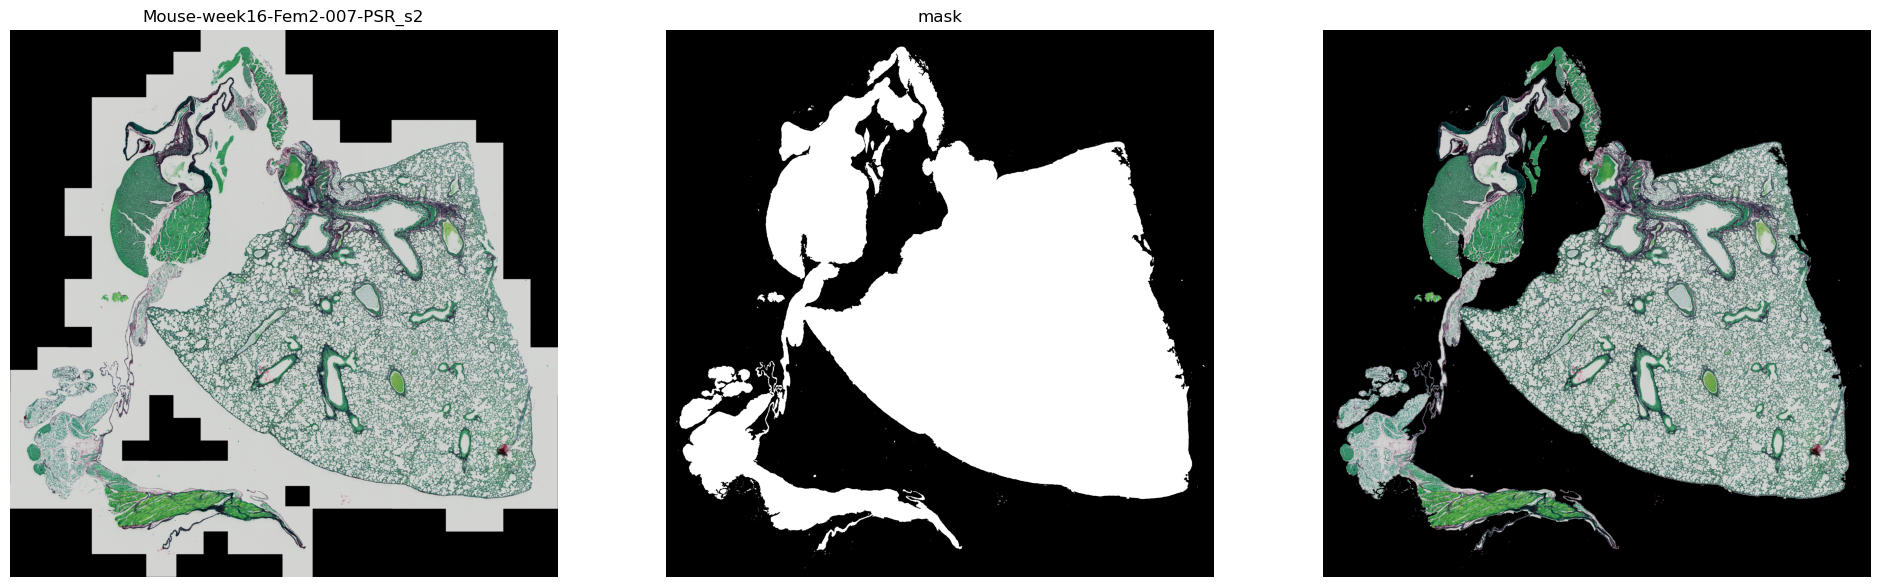

In [5]:
# plot the data
fig, axs = plt.subplots(1,3,figsize=(24,8))
axs[0].set_title(list(img_np.keys())[0])
print("image down sampling...")
image_ = img_np[list(img_np.keys())[0]][::10,::10,:]
axIm = axs[0].imshow(image_)
axs[0].set_axis_off()
axs[0].set_aspect('equal')
axs[0].autoscale(False)
axs[1].set_title("mask")
print("mask down sampling...")
mask_ = mask_np[list(mask_np.keys())[0]][::10,::10].astype(bool)
axIm = axs[1].imshow(mask_,cmap="Greys")
axs[1].set_axis_off()
axs[1].set_aspect('equal')
axs[1].autoscale(False)
print("masking image...")
image_masked = np.where(np.repeat(~mask_[:,:,np.newaxis],3,axis=2),image_,0)
axIm = axs[2].imshow(image_masked)
axs[2].set_axis_off()
axs[2].set_aspect('equal')
axs[2].autoscale(False)

In [6]:
image_np = img_np[list(img_np.keys())[0]]
mask = mask_np[list(mask_np.keys())[0]].astype(bool)
image_np = np.where(np.repeat(~mask[:,:,np.newaxis],3,axis=2),image_np,0)

## Stain Vector Separation

### Stain Vector from QuPath

In [7]:
# use the stain to color map from qupath

# mouse
stain_color_map = {
    'PSR': [0.326,0.813,0.482],
    'Counter Stain': [0.875,0.241,0.420],
    'Residual': [-0.309,-0.390,-0.867]
}
background = [208,209,207]

### Perform Stain Vector Separation

In [8]:
# specify stains of input image
stains = ['PSR',  # psr
        'Counter Stain',   # counter stain
        'Residual']      # set to null if input contains only two stains

In [9]:
def stain_vector_separation_large(image, stain_color_map, stains, batch_size=2048):
    print('stain_color_map:', stain_color_map, sep='\n')

    # create stain matrix
    W = np.array([stain_color_map[st] for st in stains]).T

    # perform standard color deconvolution
    imDeconvolved = np.zeros_like(image)

    n_rows, n_cols = image.shape[0:2]
    n_row_batches = (n_rows+batch_size-1)//batch_size
    n_col_batches = (n_cols+batch_size-1)//batch_size

    # create progress bar:
    pbar = tqdm(total=n_row_batches*n_col_batches, desc="Tile deconvolving")

    # this section can be parallelized
    for row_start in range(0,n_rows, batch_size):
        for col_start in range(0,n_cols, batch_size):
            row_end = min(row_start+batch_size, n_rows)
            col_end = min(col_start+batch_size, n_cols)

            # extract a batch from the image tile
            batch = image[row_start:row_end, col_start:col_end, :]

            # tile deconvolution
            imDeconvolved_batch = htk.preprocessing.color_deconvolution.color_deconvolution(batch, W)
            
            # update the output image
            imDeconvolved[row_start:row_end, col_start:col_end] = imDeconvolved_batch.Stains

            pbar.update(1)
    
    pbar.close()
    return imDeconvolved

In [10]:
# image color deconvolution in tiles
imDeconvolved = stain_vector_separation_large(image_np, stain_color_map, stains, batch_size=2048)

stain_color_map:
{'PSR': [0.326, 0.813, 0.482], 'Counter Stain': [0.875, 0.241, 0.42], 'Residual': [-0.309, -0.39, -0.867]}


Tile deconvolving: 100%|██████████| 484/484 [03:36<00:00,  2.24it/s]


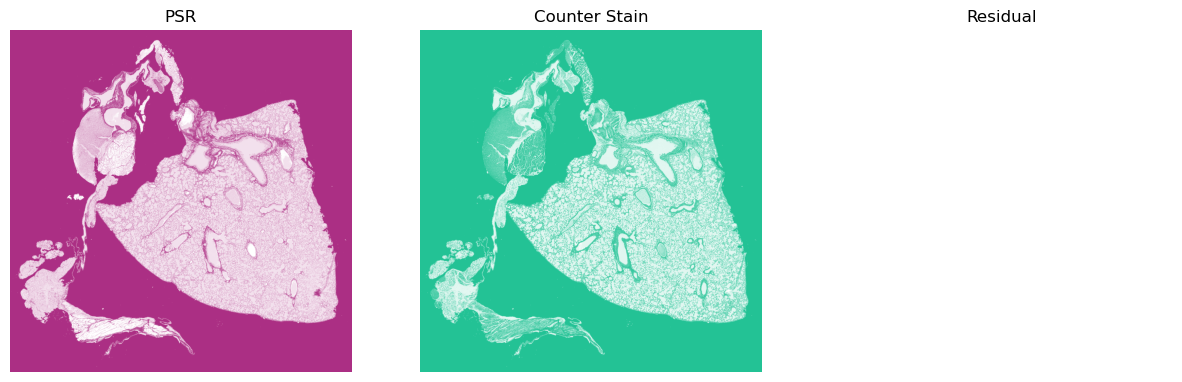

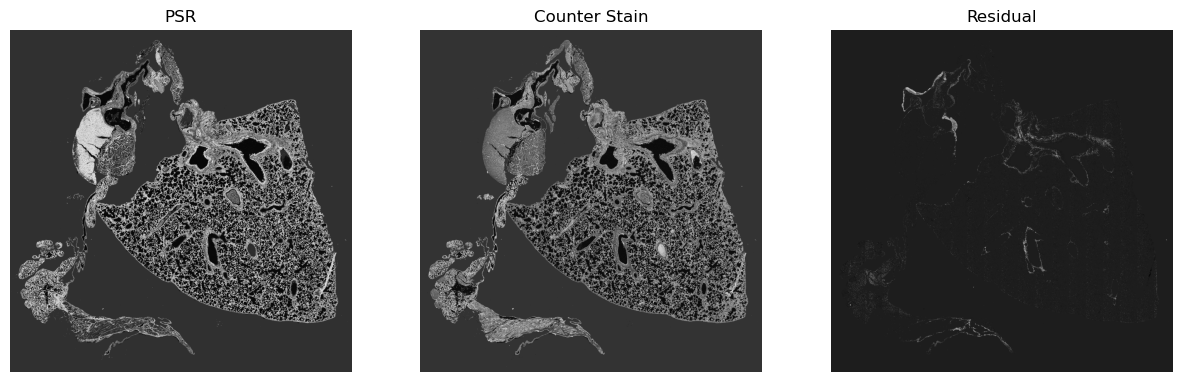

In [11]:
# Display results
N =256
fig1, axs1 = plt.subplots(1,3,figsize=(15,5))
fig2, axs2 = plt.subplots(1,3,figsize=(15,5))

for i, (st, ax) in enumerate(zip(stains,axs1)):
    vals = np.ones((N, 4))
    stain_vector = stain_color_map[st]
    stain_vector = [s if s > 0 else 0 for s in stain_vector]
    vals[:, 0] = np.linspace(1 - stain_vector[0], 1, N)
    vals[:, 1] = np.linspace(1 - stain_vector[1], 1, N)
    vals[:, 2] = np.linspace(1 - stain_vector[2], 1, N)
    # vals[:, 0] = np.linspace(0, 1 - stain_vector[0], N)
    # vals[:, 1] = np.linspace(0, 1 - stain_vector[1], N)
    # vals[:, 2] = np.linspace(0, 1 - stain_vector[2], N)
    cmp = ListedColormap(vals)

    ax.imshow(imDeconvolved[::10,::10,i], 
              vmin=np.min(imDeconvolved[::10,::10,i]),
              vmax=np.max(imDeconvolved[::10,::10,i]),
              cmap=cmp)
    ax.set_title(st)
    ax.set_axis_off()

for i, (st, ax) in enumerate(zip(stains,axs2)):
    ax.imshow(imDeconvolved[::10, ::10, i]-background[i], 
              vmin=np.min(imDeconvolved[::10,::10,i]),
              vmax=np.max(imDeconvolved[::10,::10,i]),
              cmap="gray")
    ax.set_title(st)
    ax.set_axis_off()

In [12]:
img = img_aics[list(img_aics.keys())[0]]

## Check point

In [15]:
# save the deconvolved results for quick debug
output_file = os.path.join(DATA_DIR,list(img_np.keys())[0] + "_deconv.ome.tif")

OmeTiffWriter.save(
    imDeconvolved.T, 
    output_file, 
    dim_order="CYX",
    channel_names=stains, 
    physical_pixel_sizes=img.physical_pixel_sizes,
    # channel_colors=[[],[],[]] ##TODO
    )

In [4]:
# load color deconv image for quick debug
imDeconvolved_aics = AICSImage(os.path.join(DATA_DIR,"Mouse-week16-Fem2-007-PSR_s2_deconv.ome.tif"))
print("loading deconv image")
imDeconvolved = imDeconvolved_aics.get_image_data("XYC")

mask = AICSImage(os.path.join(DATA_DIR,"Mouse-week16-Fem2-007-PSR_s2_label.tif"))
mask_ = mask.get_image_data("XY", Z=0,T=0, C=0)
print("Resampling mask...")
mask_np["Mouse-week16-Fem2-007-PSR_s2"] = resize(mask_, (imDeconvolved.shape[0], imDeconvolved.shape[1]), anti_aliasing=False)
mask_ = mask_np["Mouse-week16-Fem2-007-PSR_s2"]

loading deconv image
Resampling mask...


In [5]:
# contrast normalization with PSR channel
image_decon = imDeconvolved[:, :, 0]
p1, p2 = np.percentile(image_decon[::10,::10], (1, 99))
image_decon = exposure.rescale_intensity(image_decon, in_range = (p1, p2))

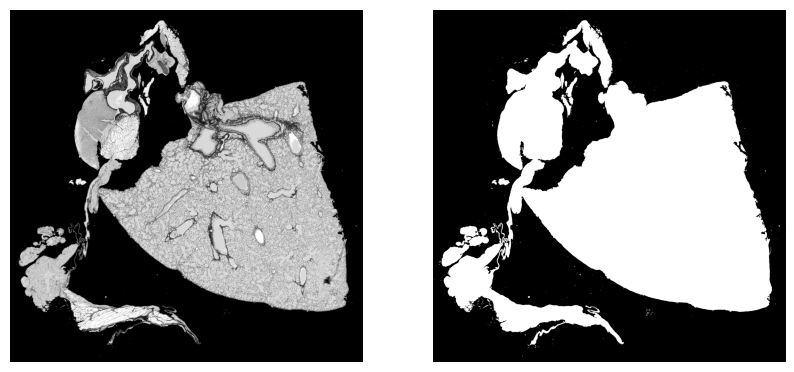

In [8]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].axis("off")
axs[0].imshow(image_decon[::10,::10],cmap="gray")
axs[1].axis("off")
axs[1].imshow(mask_np[list(mask_np.keys())[0]][::10,::10],cmap="Greys")

## Mask Centroid

In [7]:
# centre of mass of the mask
def mask_com(mask):
    m00 = np.sum(mask)
    m10 = np.sum(np.arange(mask.shape[1]) * mask)
    m01 = np.sum(np.arange(mask.shape[0])[:, np.newaxis] * mask)

    com_x = m10 / m00
    com_y = m01 / m00

    return com_x, com_y
com_x, com_y = mask_com(mask_)

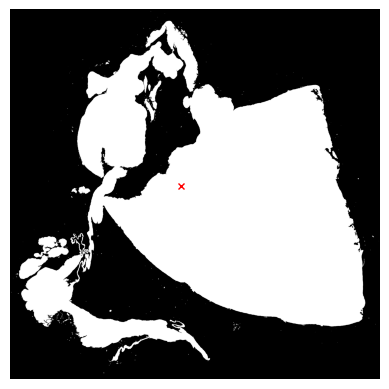

In [9]:
plt.imshow(mask_[::10,::10],cmap="Greys")
plt.axis("off")
plt.plot(com_x/10, com_y/10, marker="x", markersize=5, markeredgecolor="red")

In [10]:
# sample several tiles around the CoM
def extract_random_tiles(image, com_x, com_y, sigma=200, tile_size=2048):
    half_tile_size = tile_size//2
    # rand_offset_x = random.randint(-half_tile_size, half_tile_size)
    # rand_offset_y = random.randint(-half_tile_size, half_tile_size)
    rand_offset_x = np.random.normal(0,sigma)
    rand_offset_y = np.random.normal(0,sigma)
    
    tile_center_x = int(com_x + rand_offset_x)
    tile_center_y = int(com_y + rand_offset_y)
    
    if (tile_center_x >= half_tile_size and tile_center_x < image.shape[1]-half_tile_size and
        tile_center_y >= half_tile_size and tile_center_y < image.shape[0]-half_tile_size):
        
        tile = image[
            tile_center_y - half_tile_size: tile_center_y + half_tile_size + 1,
            tile_center_x - half_tile_size: tile_center_x + half_tile_size + 1
        ]
    
        return tile, [tile_center_x, tile_center_y]
    else:
        return None, []

In [11]:
N_OTSU_TILES = 10
OFFSET_SIGMA = 1024*1.98
tile_size = 2048

tiles = []
centers = []
while len(tiles)<N_OTSU_TILES:
    tile, center = extract_random_tiles(imDeconvolved, com_x,com_y,sigma=OFFSET_SIGMA, tile_size=tile_size)
    if tile is not None:
        tiles.append(tile)
        centers.append(center)

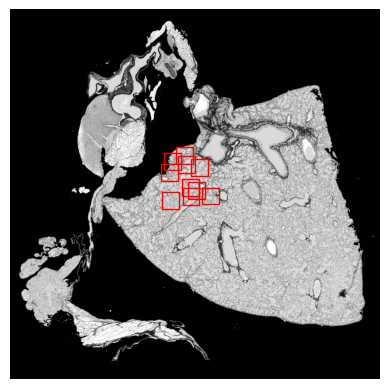

In [12]:
import matplotlib.patches as patches
fig, ax = plt.subplots(1,1)
ax.imshow(imDeconvolved[::10,::10,0],cmap="gray")
ax.axis("off")
for center in centers:
    # Create a Rectangle patch
    rect = patches.Rectangle(((center[0]-tile_size//2)//10, (center[1]-tile_size//2)//10), tile_size//10, tile_size//10, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

10it [00:00, 243.22it/s]


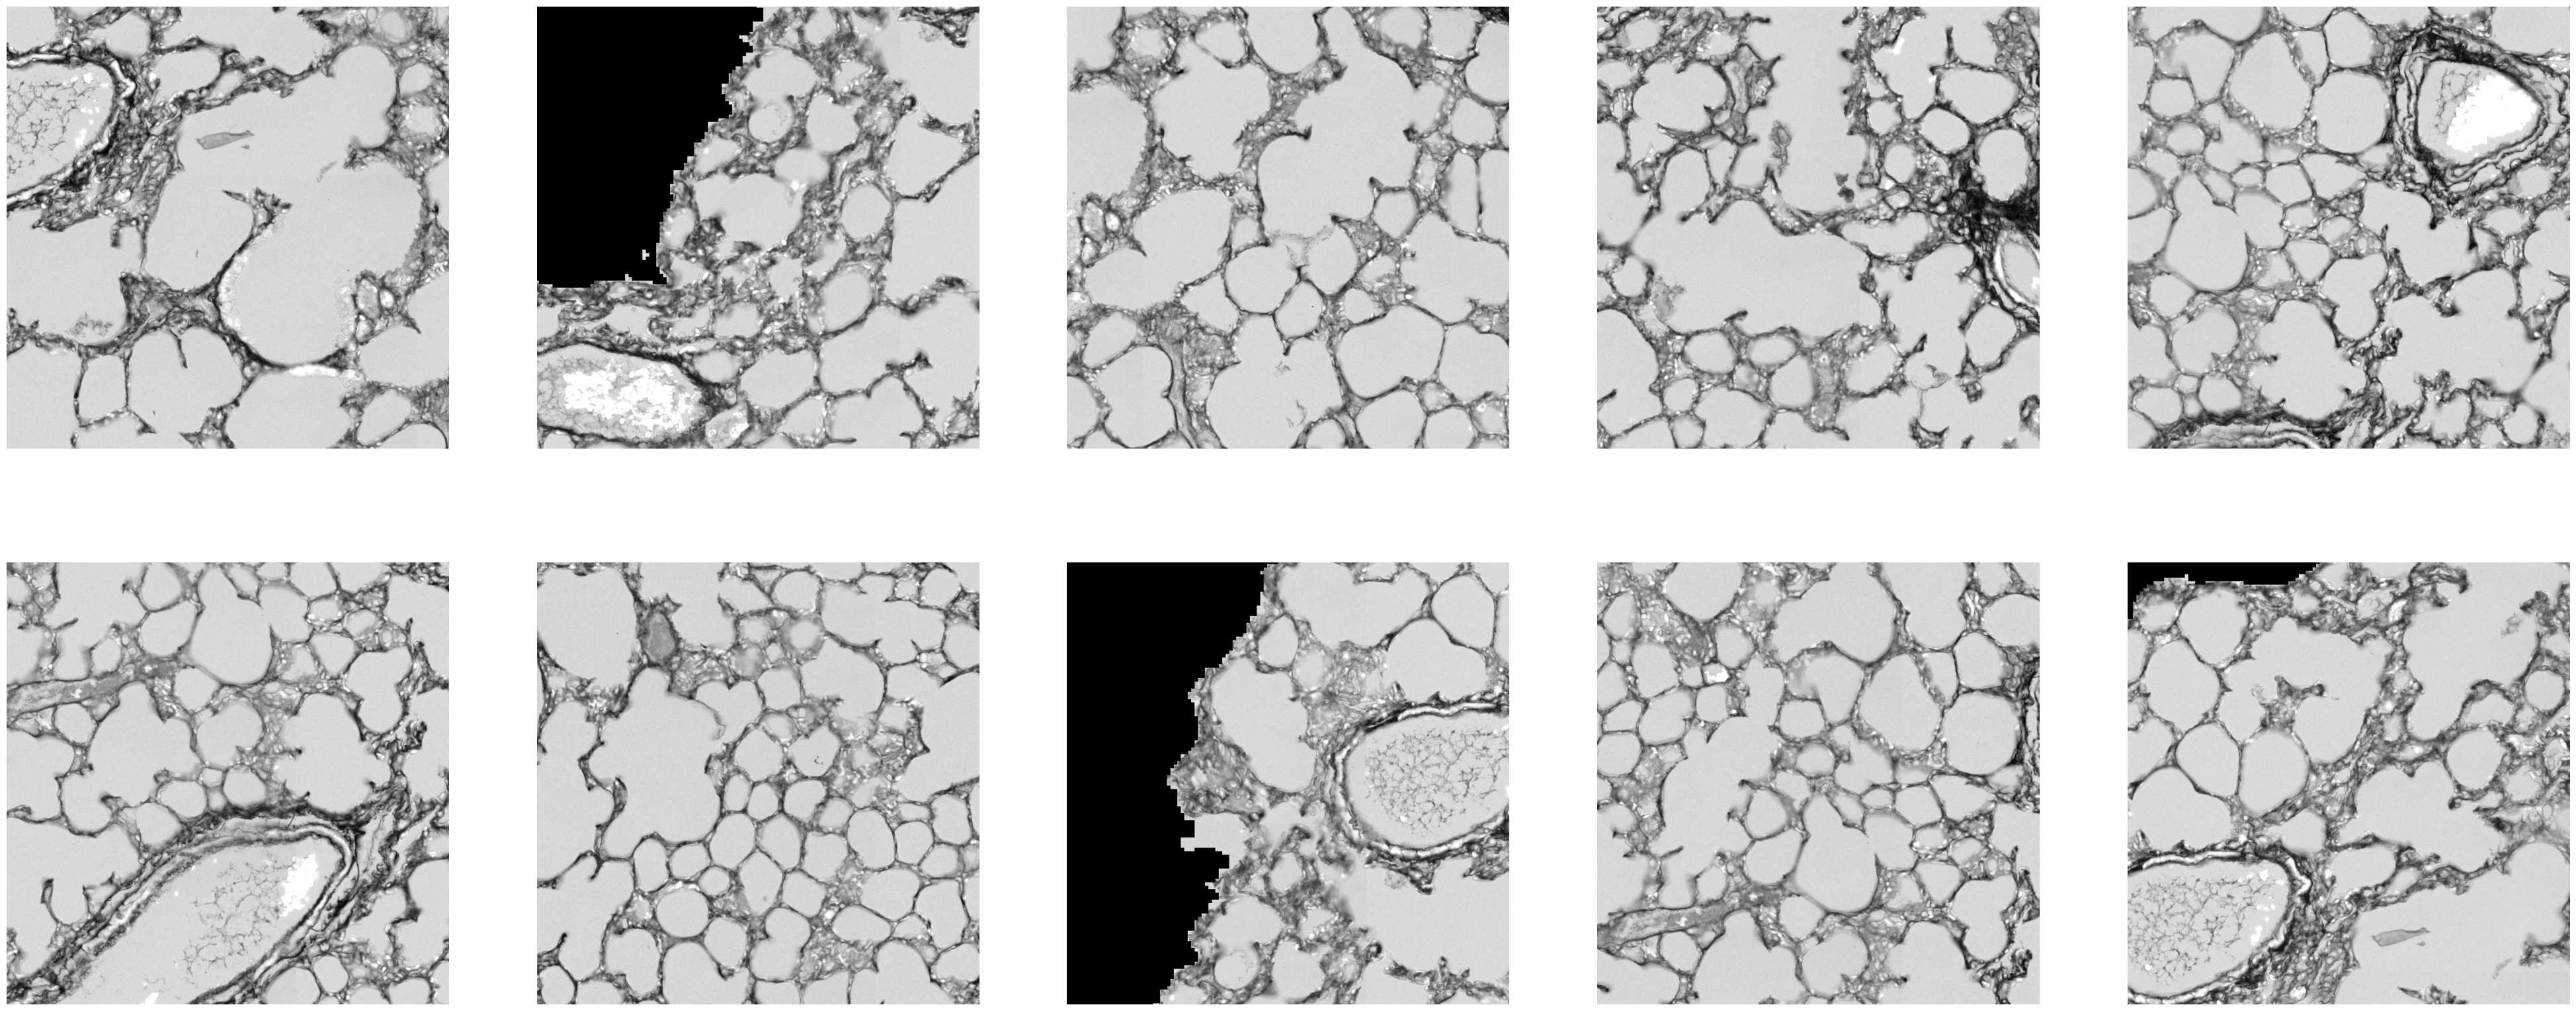

In [13]:
fig, axs = plt.subplots(2,5, figsize=(50,20))

for (tile,ax) in tqdm(zip(tiles,axs.flatten())):
    ax.imshow(tile[:,:,0],cmap="gray")
    ax.axis("off")

In [14]:
tile_thresholds = [] 
for tile in tqdm(tiles):
    thresholds = filters.threshold_multiotsu(tile, classes=5, nbins=256)
    tile_thresholds.append(thresholds)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1867479/2549480845.py:3: UserWarning: threshold_multiotsu is expected to work correctly only for grayscale images; image shape (2049, 2049, 3) looks like that of an RGB image.
  thresholds = filters.threshold_multiotsu(tile, classes=5, nbins=256)
100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


10it [00:03,  3.00it/s]


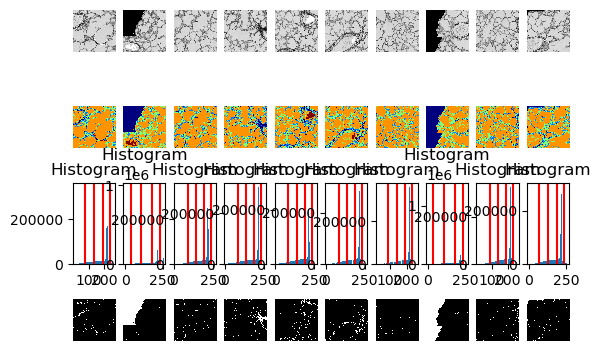

In [15]:
fig, axs = plt.subplots(4,len(tiles))

for (i, (tile,thresholds)) in tqdm(enumerate(zip(tiles,tile_thresholds))):
    tile = tile[:,:,0]
    hist, bins_center = exposure.histogram(tile)

    # Using the threshold values, we generate the threshold regions.
    regions = np.digitize(tile, bins=thresholds)

    axs[0,i].imshow(tile, cmap='gray', interpolation='nearest')
    axs[0,i].axis('off')

    axs[1,i].imshow(regions, cmap='jet', interpolation='nearest')
    axs[1,i].axis('off')

    # Plotting the histogram and the two thresholds obtained from multi-Otsu.
    axs[2,i].hist(tile.ravel(), bins=255)
    axs[2,i].set_title('Histogram')
    for thresh in thresholds:
        axs[2,i].axvline(thresh, color='r')

    # thresholding region
    # label = nuclues_filter(regions==0,roundness_thres=0.45)
    # ax[3].imshow(image_decon, 'gray', interpolation='none')
    label = np.zeros_like(regions)
    label[regions==0] = 1
    axs[3,i].imshow(label, cmap='gray', interpolation='nearest', alpha=1)
    axs[3,i].axis('off')

In [16]:
# ensembled threshold values
tile_thresholds = np.asarray(tile_thresholds)
thresholds = np.mean(tile_thresholds,axis=0)

10it [00:00, 108.75it/s]


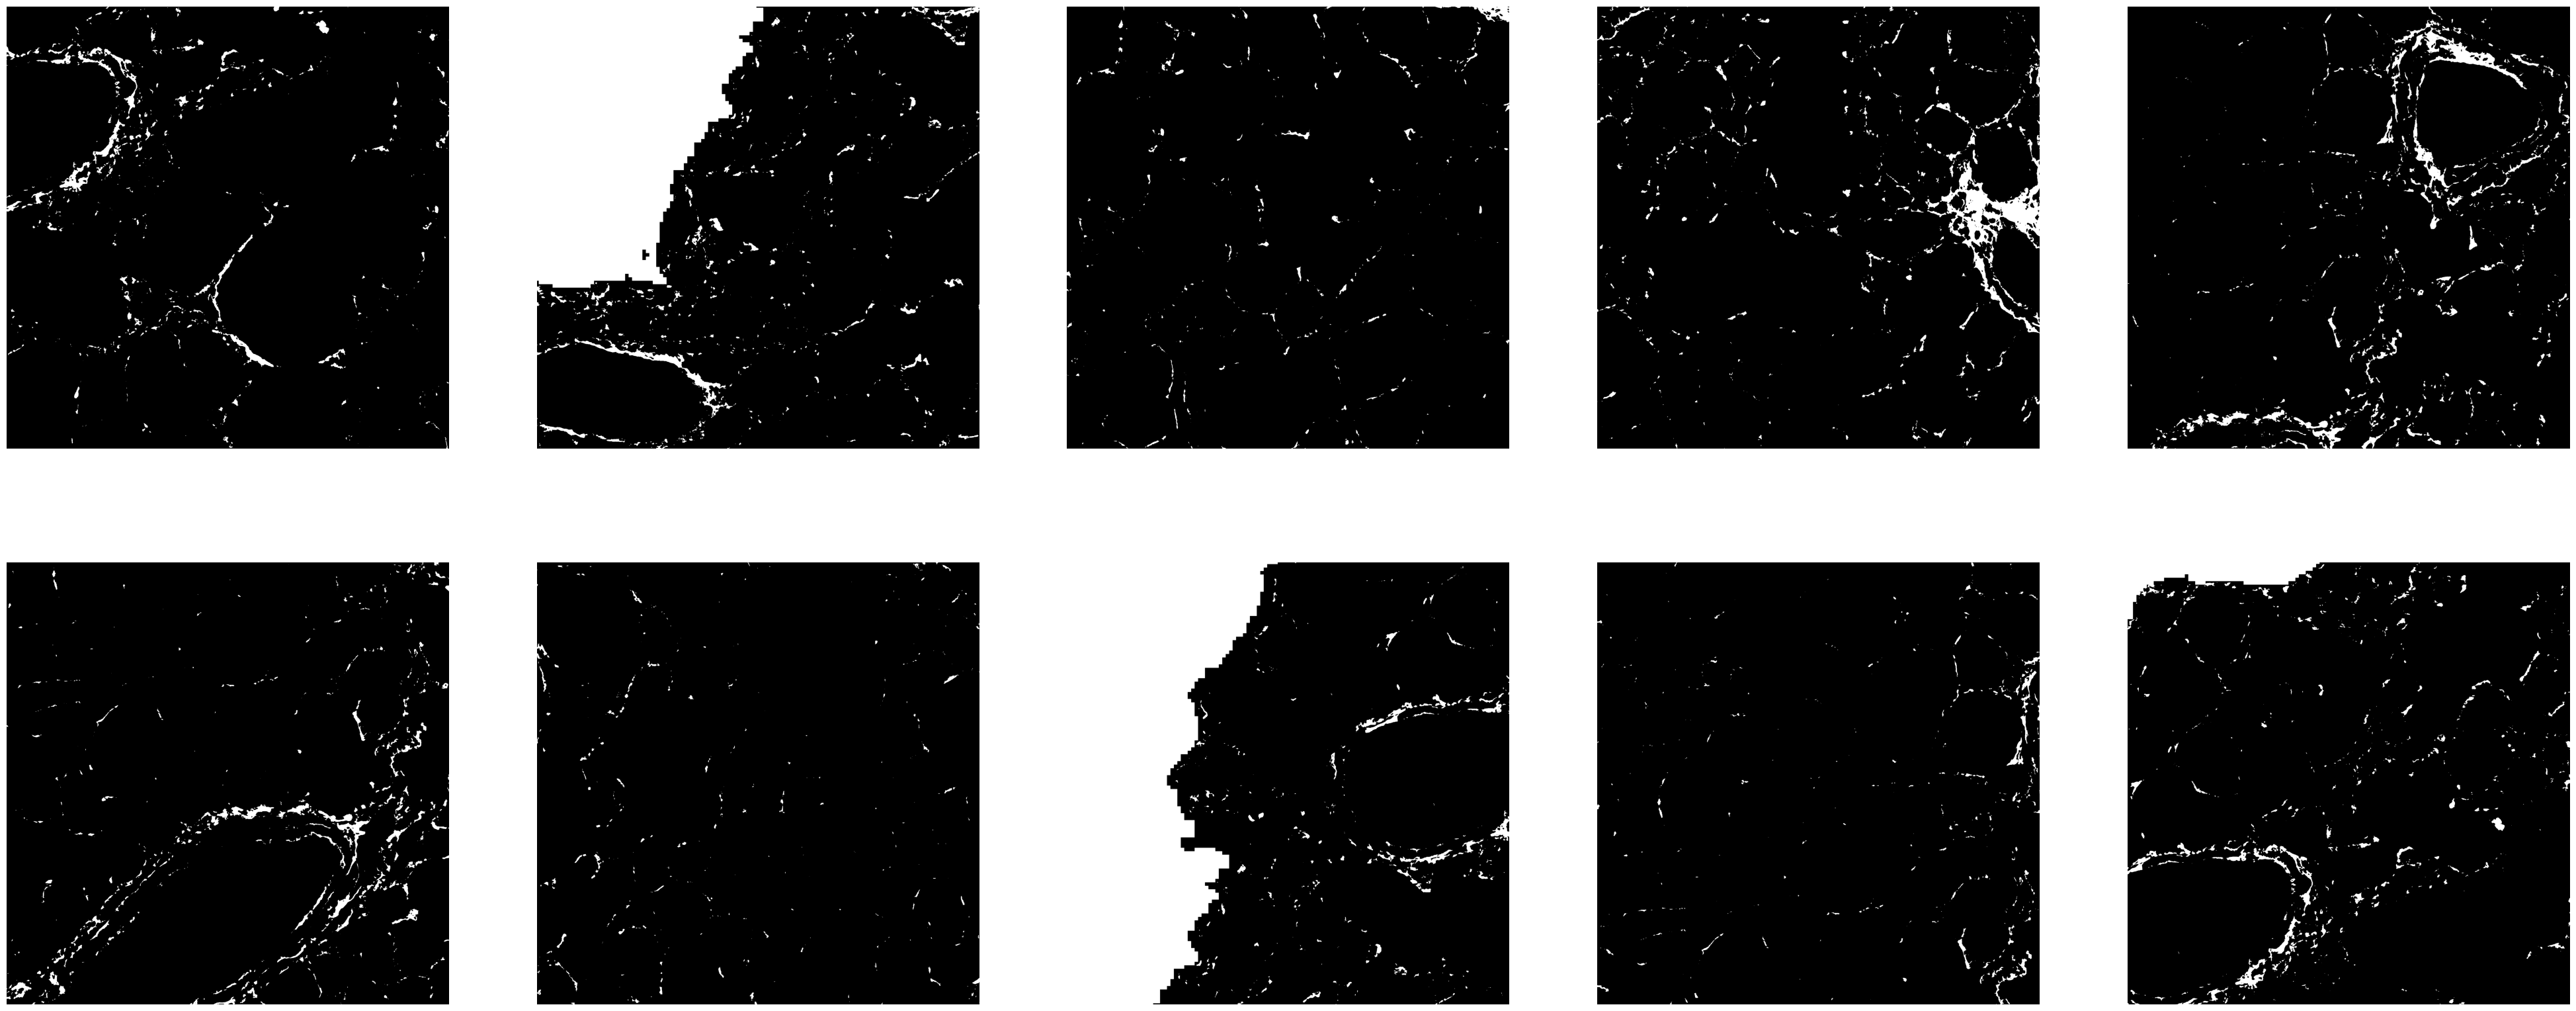

In [28]:
fig, axs = plt.subplots(2,5, figsize=(50,20))

for (tile,ax) in tqdm(zip(tiles,axs.flatten())):
    label = np.zeros_like(tile[:,:,0])
    label[tile[:,:,0]<=thresholds[0]] = 1

    ax.imshow(label,cmap="gray")
    ax.axis("off")

## Full size image thresholding

In [43]:
label = np.zeros_like(imDeconvolved[:,:,0])
label[imDeconvolved[:,:,0]<=thresholds[0]] = 1
label[mask_np[list(mask_np.keys())[0]]>0] = 0

(-0.5, 4471.5, 4473.5, -0.5)

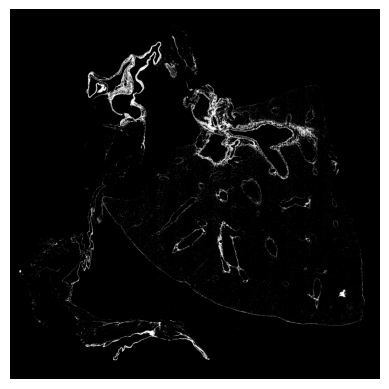

In [45]:
plt.imshow(label[::10,::10],cmap="gray")
plt.axis("off")

In [46]:
# save the label results for quick debug
output_file = os.path.join(DATA_DIR,list(mask_np.keys())[0] + "_seg.ome.tif")

OmeTiffWriter.save(
    label.T, 
    output_file, 
    dim_order="YX",
    channel_names="Collagen", 
    physical_pixel_sizes=imDeconvolved_aics.physical_pixel_sizes,
    # channel_colors=[[],[],[]] ##TODO
    )

In [ ]:
# save the downsample results for quick debug
output_file = os.path.join(DATA_DIR,list(mask_np.keys())[0] + "_psr_downsample.ome.tif")

OmeTiffWriter.save(
    imDeconvolved[::10,::10,:].T, 
    output_file, 
    dim_order="CYX",
    channel_names="Collagen", 
    physical_pixel_sizes=imDeconvolved_aics.physical_pixel_sizes,
    # channel_colors=[[],[],[]] ##TODO
    )

# save the label results for quick debug
output_file = os.path.join(DATA_DIR,list(mask_np.keys())[0] + "_seg_downsample.ome.tif")

OmeTiffWriter.save(
    label[::10,::10].T, 
    output_file, 
    dim_order="YX",
    channel_names="Collagen", 
    physical_pixel_sizes=imDeconvolved_aics.physical_pixel_sizes,
    # channel_colors=[[],[],[]] ##TODO
    )